# World Cup 2026 Outcome Forecasting – Final Project Notebook

> CS 418 – Final Project 
> Authors: Team 4 (Zeehan, Colin, Maria, Michael, Jennifer)

This notebook documents our end-to-end pipeline for forecasting FIFA Men's World Cup match outcomes and simulating tournament results.

# 1. Data

In this section, we describe the raw World Cup data, how we clean it into a single modeling table, and how we load it into Python for analysis. We assume this notebook is run from the repository root, which contains:
- `src/` – Python package with `config.py`, `cleaning.py`, `elo.py`, `features.py`, `modeling.py`, etc.
- `data/raw/` – raw CSVs from the Fjelstul World Cup Database (`matches.csv`, `teams.csv`, `group_standings.csv`, …).
- `data/processed/` – cleaned and derived tables created by our pipeline.

## 1.1 Setup and imports

In [39]:
from pathlib import Path
import sys
import importlib
import json
import pandas as pd
from IPython.display import Image, display

def find_project_root() -> Path:
    p = Path.cwd().resolve()
    for parent in [p] + list(p.parents):
        if (parent / "src" / "config.py").exists() and (parent / "reports").exists():
            return parent

PROJECT_ROOT = find_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Project config
config = importlib.import_module("src.config")

DATA_DIR = PROJECT_ROOT / "data"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIG_DIR = REPORTS_DIR / "figures"
METRICS_PATH = REPORTS_DIR / "metrics_holdout_2022.json"

# Load metrics artifact (generated by FinalCode.ipynb)
metrics = None
if METRICS_PATH.exists():
    metrics = json.loads(METRICS_PATH.read_text(encoding="utf-8"))

def show_fig(name: str, width: int = 900):
    path = FIG_DIR / name
    if not path.exists():
        print(f"Missing figure: {path} (run FinalCode.ipynb to generate it)")
        return
    display(Image(filename=str(path), width=width))

## 1.2 Raw data overview

Our primary raw source is the **Fjelstul World Cup Database** (https://github.com/jfjelstul/worldcup), provided as CSV files in `data/raw/`. The main tables we use are:

- `matches.csv`: all historical World Cup matches with team codes, goals, stage, date, and result flags.
- `teams.csv`: mapping from team codes to team names.
- `group_standings.csv`: final group standings (played, wins, draws, losses, points, etc.) for each tournament.

Below we load small samples of each table to show their structure.

In [40]:
# Raw data overview
raw_matches_path = getattr(config, "MATCHES_CSV", PROJECT_ROOT / "data" / "raw" / "matches.csv")
raw_teams_path = getattr(config, "TEAMS_CSV", PROJECT_ROOT / "data" / "raw" / "teams.csv")
group_standings_path = getattr(config, "DATA_RAW_DIR", PROJECT_ROOT / "data" / "raw") / "group_standings.csv"

raw_matches = pd.read_csv(raw_matches_path)
raw_teams = pd.read_csv(raw_teams_path)

print("Raw matches shape:", raw_matches.shape)
display(raw_matches[[
    "tournament_name","match_name","stage_name","match_date",
    "home_team_code","away_team_code","home_team_score","away_team_score"
]].head(2))

print("Raw teams shape:", raw_teams.shape)
display(raw_teams[["team_code","team_name","federation_name"]].head(2))

# Group standings are not required for our modeling pipeline, so show only presence + shape
raw_group = pd.read_csv(group_standings_path)
print("Group standings present. Shape:", raw_group.shape)

Raw matches shape: (1248, 37)


,tournament_name,match_name,stage_name,match_date,home_team_code,away_team_code,home_team_score,away_team_score
0,1930 FIFA Men's World Cup,France vs Mexico,group stage,1930-07-13,FRA,MEX,4,1
1,1930 FIFA Men's World Cup,United States vs Belgium,group stage,1930-07-13,USA,BEL,3,0


Raw teams shape: (88, 14)


,team_code,team_name,federation_name
0,DZA,Algeria,Algerian Football Federation
1,AGO,Angola,Angolan Football Federation


Group standings present. Shape: (626, 19)


## 1.3 Cleaning pipeline: from raw matches to matches_clean

We use `src.cleaning.clean_matches` (via `run_clean_and_save`) to transform the raw `matches.csv` into a single modeling table `matches_clean.parquet`. The main steps are:

- **Standardize column names**:
  - `home_team_code` to `team_home`
  - `away_team_code` to `team_away`
  - `home_team_score` to `score_home`
  - `away_team_score` to `score_away`
  - `stage_name` to `stage`
  - `group_name` to `group`
  - `match_date` to `date`
  - plus additional columns like `city`, `country`, `stadium`, and result flags.
- **Parse dates and derive year**:
  - Convert `date` to a proper datetime and derive the `year` column.
- **Filter and clean**:
  - Keep only men's World Cup finals era: `1930–2022`.
  - Remove rows with missing teams/scores/dates.
  - Exclude women’s tournaments and historical teams that no longer exist (e.g., West Germany, Czechoslovakia, Yugoslavia, etc.).
- **Add outcome label**:
  - Compute `goal_diff_home = score_home - score_away`.
  - Derive `match_result_1x2 ∈ {win, loss, draw}` from the home team’s perspective.
- **Sort chronology & save**:
  - Sort by `(year, date)` and write the result to `data/processed/matches_clean.parquet`.

**Key variables in `matches_clean`:**

- `team_home`, `team_away`: 3-letter FIFA team codes for the home and away teams.
- `score_home`, `score_away`: full-time goals scored by each team.
- `date`, `year`: match date and calendar year.
- `stage`: textual stage name (e.g., “group stage”, “round of 16”, “quarter-final”, etc.).
- `group`: group identifier (e.g., Group A/B/…), populated for group matches.
- `goal_diff_home`: goal differential from the home team’s perspective.
- `match_result_1x2`: categorical target label with values `{win, draw, loss}` for the home team.

**Filtering/cleaning decisions:**

- Restricted to men’s World Cup finals between **1930 and 2022**.
- Dropped matches with missing teams, scores, or dates.
- Excluded women’s tournaments and historical entities (e.g., West Germany, Yugoslavia) to match modern FIFA team identities.
- Sorted chronologically, so Elo and other time-dependent features can be computed correctly.

## 1.4 Label distribution for match_result_1x2
Across all World Cup finals matches from 1930–2022, the `match_result_1x2` label is moderately imbalanced. Home wins are the most common outcome, draws are less frequent, and home losses are somewhere in between. This reflects both home-field advantage (when relevant) and the fact that neutral venues still tend to produce more wins than draws.

In [41]:
# Load cleaned dataset (kept compact for PDF)
CLEAN_PATHS = [
    PROJECT_ROOT / "data" / "processed" / "matches_clean.parquet",
    PROJECT_ROOT / "data" / "processed" / "matches_clean.csv",
    PROJECT_ROOT / "matches_clean.parquet",
    PROJECT_ROOT / "matches_clean.csv",
]

matches_clean = None
for p in CLEAN_PATHS:
    if p.exists():
        matches_clean = pd.read_parquet(p) if p.suffix == ".parquet" else pd.read_csv(p)
        print("Loaded cleaned data:", p)
        break

print("matches_clean shape:", matches_clean.shape)

Loaded cleaned data: C:\CS418\project-check-in-team-4\worldcup-predictor\data\processed\matches_clean.parquet
matches_clean shape: (755, 40)


In [42]:
label_counts = matches_clean["match_result_1x2"].value_counts().sort_index()
label_prop = (label_counts / label_counts.sum()).round(3)

summary = (
    pd.DataFrame({"count": label_counts, "proportion": label_prop})
    .reset_index()
    .rename(columns={"match_result_1x2": "label"})
)
display(summary)

,label,count,proportion
0,draw,144,0.191
1,loss,201,0.266
2,win,410,0.543


# 2. ML/Stats

## 2.1 Multiclass Logistic Regression
### Feature engineering and temporal split 

We engineer a minimal feature set for each match based on team strength and context:

- Elo ratings before the match:
  - `elo_home_pre` – home team Elo.
  - `elo_away_pre` – away team Elo.
  - `elo_delta_pre = elo_home_pre - elo_away_pre`.
- Context flag:
  - `is_knockout` – 1 for knockout matches, 0 for group stage.

We then perform a temporal train/test split, training on all tournaments before 2022 and holding out the 2022 World Cup for evaluation. This mimics a realistic forecasting setting where we train on past editions and test on the most recent one.

In [43]:
# Model 1 metrics (2022 holdout)
if metrics is None:
    print("Run FinalCode.ipynb to generate metrics.")
else:
    m1 = metrics["models"]["model1_logreg"]
    rows = [
        ["Accuracy", m1.get("accuracy")],
        ["Macro F1", m1.get("macro_f1")],
        ["Log loss", m1.get("log_loss")],
    ]
    display(pd.DataFrame(rows, columns=["Metric", "Value"]))

,Metric,Value
0,Accuracy,0.491803
1,Macro F1,0.297404
2,Log loss,1.481635


Our results show that the model performs well at predicting wins, but it struggles heavily with ties. This makes sense because ties are both rarer in the dataset and harder to capture using simple Elo-based features. As a result, the model tends to push borderline games toward either a win or a loss instead of predicting a draw.

## 2.2 Random Forest

In [44]:
# Model 2 metrics (2022 holdout)
if metrics is None:
    print("Run FinalCode.ipynb to generate metrics.")
else:
    m2 = metrics["models"]["model2_random_forest"]
    rows = [
        ["Accuracy", m2.get("accuracy")],
        ["Macro F1", m2.get("macro_f1")],
        ["Log loss", m2.get("log_loss")],
    ]
    display(pd.DataFrame(rows, columns=["Metric", "Value"]))

,Metric,Value
0,Accuracy,0.508197
1,Macro F1,0.429149
2,Log loss,1.619276


Random forests can capture non-linear relationships and feature interactions that a linear model cannot. In our setting, this can improve performance on certain outcome types, but it may also produce less smooth probability estimates (which can affect log loss). We compare both models using the same 2022 holdout metrics below.

# 3. Visualization

## 3.1 Elo trajectories for selected teams

Elo ratings summarize estimated team strength over time. Here we visualize how Elo evolves for a few historically strong teams across World Cups. This helps us see long-term trends (e.g., sustained strength vs cycles of dominance and decline).

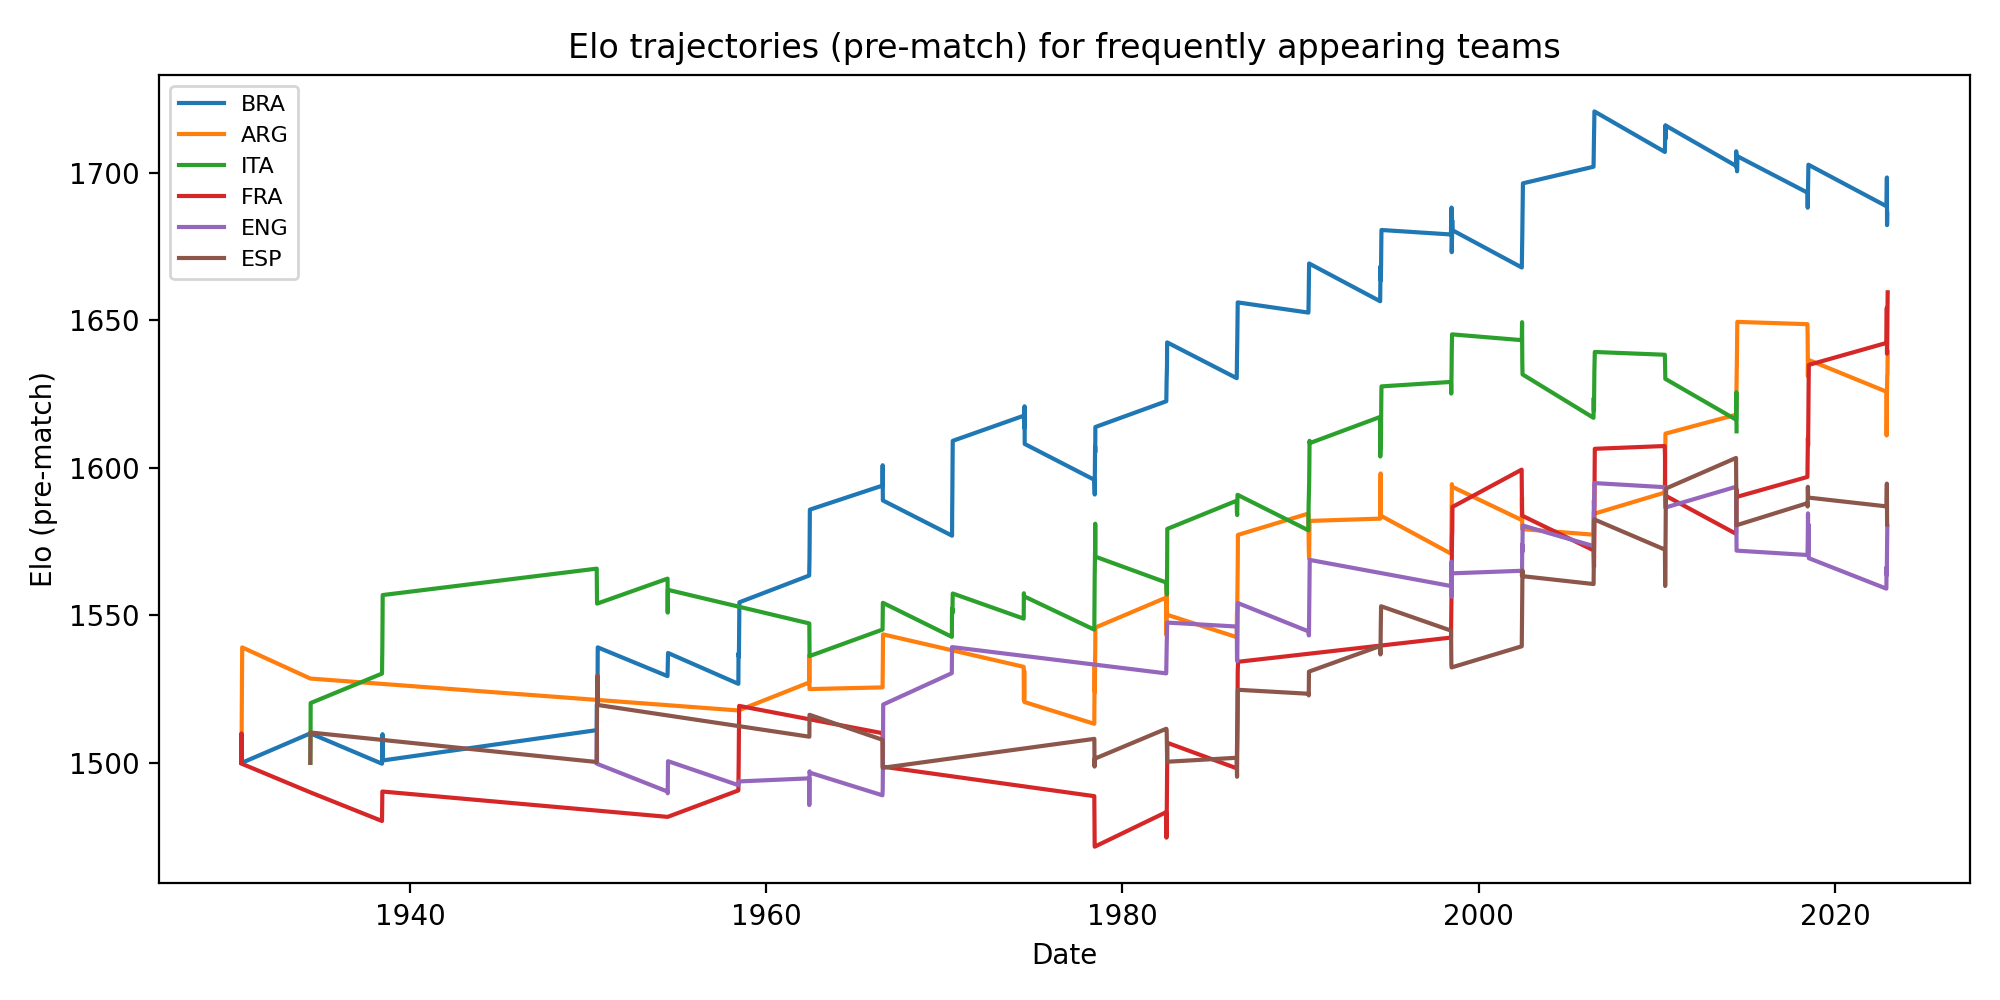

In [45]:
# Elo trajectories figure (generated by FinalCode.ipynb)
show_fig("elo_trajectories.png", width=900)

Elo ratings summarize estimated team strength over time. The plot below shows example trajectories for several teams, illustrating long-run differences in strength and periods of dominance/decline.

## 3.2 Confusion matrix heatmap (2022 holdout)

Confusion matrices summarize how predictions align with true outcomes. Each heatmap shows where the model confuses outcomes (e.g., predicting win when the true label is draw).

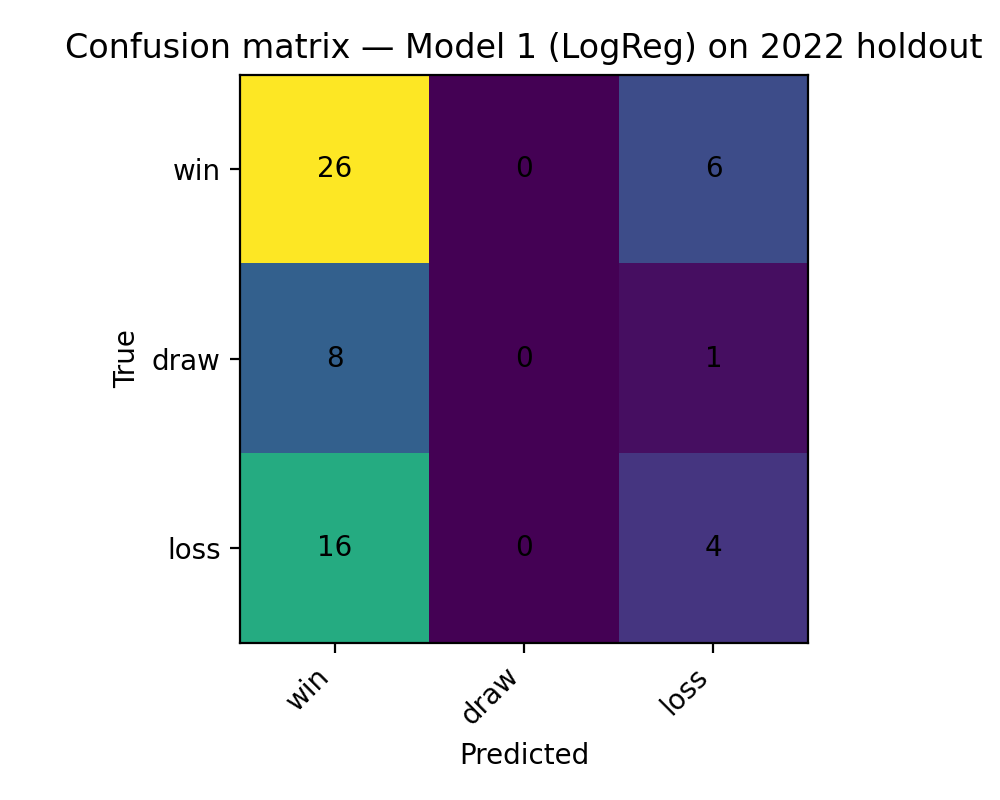

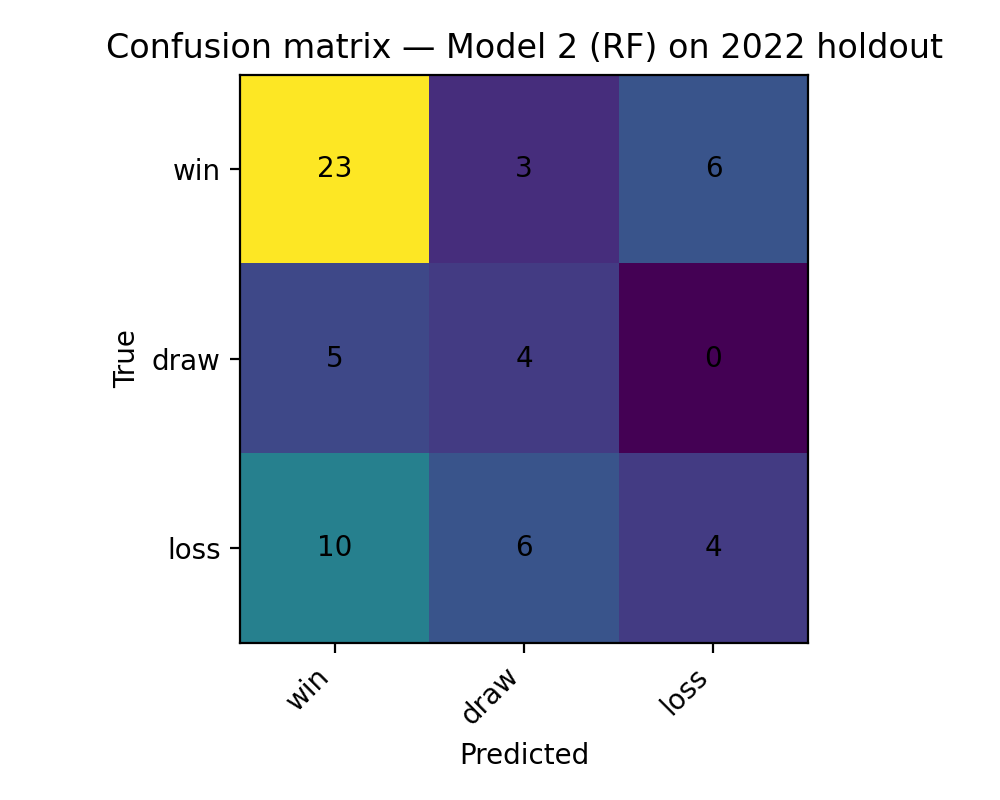

In [50]:
# Confusion matrices (2022 holdout) — figures generated by FinalCode.ipynb
show_fig("cm_model1_2022.png", width=400)
show_fig("cm_model2_2022.png", width=400)

We care about more than accuracy because the three classes are imbalanced and draws are harder to predict. The confusion matrices help diagnose whether errors are mostly “near-miss” (win vs draw) or systematic.

# 4. Additional Work

## 4.1 Tournament simulation using the baseline model

As an additional deliverable, we plug our trained model into a tournament simulation to approximate World Cup outcomes. The simulator:

- Uses a final Elo snapshot per team.
- Uses the trained logistic regression model to generate match outcome probabilities.
- Simulates group stages and knockout rounds, enforcing that knockout matches cannot end in a draw.
- Can be repeated many times with different random seeds to approximate champion probabilities.

We focus on simulating the **2022 World Cup** using the actual group compositions and format.

## 4.2 Permutation feature importance (extra deliverable)

As an additional analysis deliverable, we compute permutation importance on the 2022 holdout to estimate which features most affect predictive performance. This complements model metrics by adding interpretability.

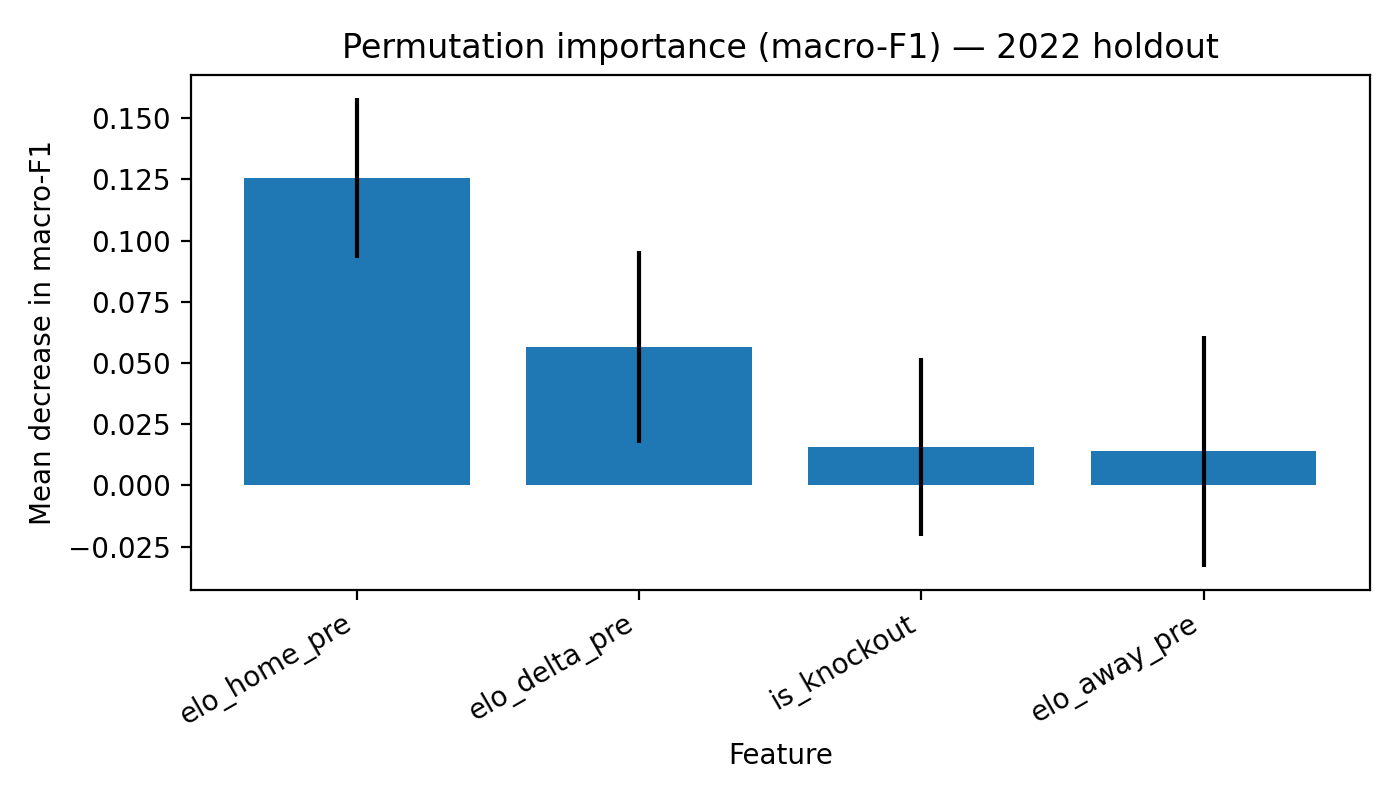

In [47]:
show_fig("perm_importance.png", width=900)

# 5. Results

We evaluate on the 2022 World Cup as a strict temporal holdout (train on years < 2022). The table below is read from `reports/metrics_holdout_2022.json` generated by `FinalCode.ipynb`.

In [48]:
# Compact comparison table (2022 holdout)
if metrics is None:
    print("Run FinalCode.ipynb to generate metrics.")
else:
    m1 = metrics["models"]["model1_logreg"]
    m2 = metrics["models"]["model2_random_forest"]
    comp = pd.DataFrame(
        [
            ["Multinomial Logistic Regression", m1.get("accuracy"), m1.get("macro_f1"), m1.get("log_loss")],
            ["Random Forest", m2.get("accuracy"), m2.get("macro_f1"), m2.get("log_loss")],
        ],
        columns=["Model", "Accuracy", "Macro F1", "Log loss"],
    )
    display(comp)

,Model,Accuracy,Macro F1,Log loss
0,Multinomial Logistic Regression,0.491803,0.297404,1.481635
1,Random Forest,0.508197,0.429149,1.619276


### Discussion
- **Accuracy vs Macro F1:** Macro F1 treats each class equally, which is important when draws are less frequent and harder to predict.
- **Log loss:** If probabilities are used downstream (e.g., simulation), log loss matters because it rewards well-calibrated confidence.
- In practice, we would choose the model based on the metric that best matches the project goal (classification accuracy vs probability quality), and we would iterate on features to better capture draw dynamics.

# 6. Appendix

## 6.1 Group member contributions

**Zeehan:** 

**Colin:** 

**Michael:** 

**Maria:** 

**Jennifer:** 
